In [1]:
"""
@File    : EDU_tokenomics_20250113.ipynb
@Create  : 2025/01/13 12:04:46
@Modify  : 2025/01/13 12:04:46
@Author  : Flora Sun
@Contact : floras@animocabrands.com
@Desc    : None
"""


'\n@File    : EDU_tokenomics_20250113.ipynb\n@Create  : 2025/01/13 12:04:46\n@Modify  : 2025/01/13 12:04:46\n@Author  : Flora Sun\n@Contact : floras@animocabrands.com\n@Desc    : None\n'

In [275]:
cd '/Users/floras/Desktop/unique-user'

/Users/floras/Desktop/unique-user


In [3]:
import pandas as pd
import numpy as np
import os
import importlib
import sybil_functions
import trino_fetch_results
from collections import Counter
from concurrent.futures import ThreadPoolExecutor
import networkx as nx
from cdlib import algorithms
import networkx as nx
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from sklearn.ensemble import IsolationForest
import parameters
import matplotlib.pyplot as plt


importlib.reload(sybil_functions)
importlib.reload(trino_fetch_results)
importlib.reload(parameters)


from sybil_functions import (
    read_from_multiple_csv,
    stretched_sigmoid,
    file_name_lst,
    check_contract,
)

from trino_fetch_results import check_frequent_wallets, wallets_monthly_info, query_test

from parameters import trino_data_column_names

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}


# Import Data

### Core wallet (airdrop wallet) 

In [4]:
# core wallet df
all_core_wallet_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/oc_testnet_15Jan/OC_Testnet_Points.csv",
    header=None,
)
all_core_wallet_df.columns = ["address", "points"]
print(all_core_wallet_df.shape)
all_core_wallet_df.head()

(351642, 2)


,address,points
0,0x83e46e6e193b284d26f7a4b7d865b65952a50bf2,1021212
1,0xb403df6a3a8895d9a5ecfa7ec799bb60de28c75c,356403
2,0xa482ae7d753b33cb06fd6872443e902cb6bee592,215177
3,0xf0276d7d27a98cbed1635e7079716e9eed73f329,72485
4,0xf5e8a439c599205c1ab06b535de46681aed1007a,72123


In [227]:
oc_wallet_lst = all_core_wallet_df["address"].tolist()
oc_wallet_set = set(oc_wallet_lst)

In [5]:
used_core_wallet_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/oc_testnet_15Jan/used_wallets.csv"
)
used_core_wallet_df.columns = ["address"]
print(used_core_wallet_df.shape)
used_core_wallet_df.head()

(148256, 1)


,address
0,0x0000000000000000000000000000000000007495
1,0x00000000000a067fb775a27671542d381ba30e53
2,0x00000000000ebccded8ad28e591c96ac3337be59
3,0x000000000043cd9d396f9d5a7ea1cffe6391a302
4,0x0000000000521014208ed637db9cf4cd6f548154


In [225]:
# Get core wallet list
core_wallet_lst = used_core_wallet_df["address"].tolist()
# Get core wallet set
core_wallet_set = set(core_wallet_lst)

### Wallets to remove

In [8]:
removing_wallets_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/oc_testnet_15Jan/removing_wallets/contract_wallets.txt",
    header=None,
)
removing_wallets_df.columns = ["address"]

removing_wallets_df.head()

,address
0,0x3a05e5d33d7ab3864d53aaec93c8301c1fa49115
1,0x931ddbfab6d12a5ccbf0db6b70daae747076533a
2,0xed7525946a09056c6aae29941b8323017382050e
3,0x0ec68c5b10f21effb74f2a5c61dfe6b08c0db6cb
4,0x28f9b9aa3b885d67abb298491bbba65171c3392e


In [9]:
# Get removing wallet list
removing_wallet_lst = removing_wallets_df["address"].tolist()
# Get removing wallet set
removing_wallet_set = set(removing_wallet_lst)

### Transaction data 

In [10]:
trans_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/oc_testnet_15Jan/transaction_history/transaction_native_df_sum.csv"
)
print(trans_df.shape)
# remove self transactions
trans_df = trans_df[trans_df["from_address"] != trans_df["to_address"]]
# remove removing-wallet transactions
trans_df = trans_df[
    ~(
        trans_df["from_address"].isin(removing_wallet_set)
        | trans_df["to_address"].isin(removing_wallet_set)
    )
]
# keep only core of sybil transactions
trans_df = trans_df[
    trans_df["from_address"].isin(core_wallet_set)
    | trans_df["to_address"].isin(core_wallet_set)
]
print(trans_df.shape)
trans_df.head()

(273791, 3)
(251664, 3)


,from_address,to_address,count
0,0x0000000000000000000000000000000000000000,0xfcb9bde39c289eb8b2270abf4e129da630cacebe,1
2,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0476fc79c97f68e3e32c37b83691d99da5464cec,1
3,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x04a9ae552e5c43cc6af695797c702795871d4c8d,1
4,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0da21e19274b09d787fecc35997cecf4e1d67a0b,1
5,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0de5a5d50453e702ad66d3fcf7c986f408019ffd,1


### Monthly data

In [11]:
trino_monthly_df = pd.read_csv(
    "/Users/floras/Desktop/unique-user/-Data/oc_testnet_15Jan/monthly_info/processed_monthly_info_df.csv"
)
trino_monthly_df = trino_monthly_df.set_index("address")
print(trino_monthly_df.shape)
trino_monthly_df.head()

(148256, 5)


,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days
address,,,,,
0x0000000000000000000000000000000000007495,0.041382,1,1,2024-11-25,1
0x00000000000a067fb775a27671542d381ba30e53,67.154409,221,31,2025-01-11,84
0x00000000000ebccded8ad28e591c96ac3337be59,7261.079740,5789,4359,2025-01-13,364
0x000000000043cd9d396f9d5a7ea1cffe6391a302,0.021883,4,3,2024-12-30,4
0x0000000000521014208ed637db9cf4cd6f548154,1.940654,5,4,2024-12-30,4


# remove contract/hot wallets & transactions

## Define wallets to be checked based on the number of interacted wallets

In [12]:
def columns_unique_items(df, column_name_lst):
    unique_items = []
    for column_name in column_name_lst:
        unique_items.extend(df[column_name].unique().tolist())
    return list(set(unique_items))

In [13]:
all_wallets = columns_unique_items(trans_df, ["from_address", "to_address"])
print(len(all_wallets))

146406


In [14]:
def columns_item_count(unique_pairs_df, w_cols=["wallet_a", "wallet_b"]):
    # Flatten the selected columns into a single list
    wallet_z = unique_pairs_df[w_cols].values.flatten()
    # Count occurrences of each wallet using Counter
    wallet_z_count = Counter(wallet_z)
    # Convert the Counter object into a DataFrame
    wallet_z_count_df = pd.DataFrame(
        wallet_z_count.items(), columns=["wallet", "interacted_wallets"]
    )
    # Return the resulting DataFrame
    return wallet_z_count_df

In [15]:
def columns_item_unique_pairs(
    raw_transaction_df, address_cols=["from_address", "to_address"]
):
    # Ensure input columns are present in the DataFrame
    if not all(col in raw_transaction_df.columns for col in address_cols):
        raise ValueError(f"Columns {address_cols} not found in the DataFrame.")

    # Convert the columns to strings to ensure consistent dtype
    raw_transaction_df[address_cols] = raw_transaction_df[address_cols].astype(str)
    # Create sorted pairs using numpy operations (faster than apply)
    pairs = np.sort(raw_transaction_df[address_cols].to_numpy(dtype=str), axis=1)
    # Deduplicate pairs using numpy.unique
    unique_pairs = np.unique(pairs, axis=0)
    # Create a DataFrame for unique pairs
    unique_pairs_df = pd.DataFrame(unique_pairs, columns=["wallet_a", "wallet_b"])

    return unique_pairs_df

In [16]:
def columns_item_unique_pair_counts(
    raw_transaction_df, address_cols=["from_address", "to_address"]
):
    unique_pairs_df = columns_item_unique_pairs(raw_transaction_df, address_cols)
    # Use the optimized columns_item_count function
    wallet_count = columns_item_count(unique_pairs_df, w_cols=["wallet_a", "wallet_b"])
    # Reset index before returning
    wallet_count.reset_index(drop=True, inplace=True)
    return wallet_count

In [19]:
# sample_wallet_pair_count_df = columns_item_unique_pair_counts(native_trans_df_0)
# sample_wallet_pair_count_df.head()

In [20]:
# check_contract_wallet_lst = sample_wallet_pair_count_df[
#     sample_wallet_pair_count_df["interacted_wallets"] > 1
# ]["wallet"].tolist()
# check_contract_wallet_lst[:5]

In [17]:
def refine_lst(lst, exclude_lst):
    exclude_set = set(exclude_lst)
    return [x for x in lst if x not in exclude_set]

In [22]:
# # remove core wallets from check_contract_wallet_lst
# check_contract_wallet_lst = refine_lst(check_contract_wallet_lst, core_wallet_lst)

## get contract wallets list

In [18]:
def check_contract_wallet_addresses(wallet_addresses, max_threads=10):
    contract_wallets = []
    with ThreadPoolExecutor(max_threads) as executor:
        # Submit tasks for concurrent execution
        futures = [
            executor.submit(check_contract, wallet) for wallet in wallet_addresses
        ]
        for future in futures:
            results = future.result()
            if results:
                contract_wallets.append(results)
    return contract_wallets

In [24]:
# check_contract_wallet_addresses(check_contract_wallet_lst[:10])

## get hot wallets list

In [25]:
# check_frequent_wallets(
#     check_contract_wallet_lst[10:15], start_date_="2024-12-01", end_date_="2024-12-02"
# )

## remove contract/hot transactions

In [19]:
def filter_blacklist_transactions(df, col_lst, contract_lst):
    for col in col_lst:
        df = df[~df[col].isin(contract_lst)]
    return df

# Define weight

In [20]:
def columns_item_unique_pair_sums(
    raw_transaction_df_0,
    address_cols=["from_address", "to_address"],
    sum_col="tx_count",
):
    raw_transaction_df = raw_transaction_df_0.copy()
    raw_transaction_df["pair"] = raw_transaction_df[address_cols].apply(
        lambda x: tuple(sorted(x)), axis=1
    )
    unique_pair_sums = raw_transaction_df.groupby("pair")[sum_col].sum().reset_index()
    unique_pair_sums["node_a"] = unique_pair_sums["pair"].apply(lambda x: x[0])
    unique_pair_sums["node_b"] = unique_pair_sums["pair"].apply(lambda x: x[1])
    unique_pair_sums.drop(columns=["pair"], inplace=True)
    return unique_pair_sums

In [21]:
def sigmoid_weight_transform(df, turning_point=2, col="tx_count"):
    df["weight"] = df[col].apply(lambda x: stretched_sigmoid(x, 2 / turning_point))
    return df

In [22]:
trans_df["count"].describe()

count    251664.000000
mean          1.915987
std           4.411918
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         658.000000
Name: count, dtype: float64

In [23]:
trans_df

,from_address,to_address,count
0,0x0000000000000000000000000000000000000000,0xfcb9bde39c289eb8b2270abf4e129da630cacebe,1
2,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0476fc79c97f68e3e32c37b83691d99da5464cec,1
3,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x04a9ae552e5c43cc6af695797c702795871d4c8d,1
4,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0da21e19274b09d787fecc35997cecf4e1d67a0b,1
5,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0de5a5d50453e702ad66d3fcf7c986f408019ffd,1
...,...,...,...
273785,0xfffdea87ca2c7ee37fc704000c9705e777ae405a,0x4fa4167b3c94a80416bbc768fb919bf3ace9f8c2,2
273786,0xfffdea87ca2c7ee37fc704000c9705e777ae405a,0xf7b02288475a588c771e10ec18075cea920aa8f9,1
273788,0xffff71eff595691dac6fb23853297ce5fcd6f331,0x58d5d56573801cc1f2c50785b327e7df04f78b98,1
273789,0xffffcb0bbd0880ac22750145926871392407310d,0x34f66b62893969f155fbf4d512480a270ec71bcf,3


In [24]:
columns_item_unique_pair_sums(trans_df, sum_col="count")

,count,node_a,node_b
0,7,0x0000000000000000000000000000000000000000,0x8f614cb69fec993251e491daee1fb3a640f1b36c
1,1,0x0000000000000000000000000000000000000000,0xfcb9bde39c289eb8b2270abf4e129da630cacebe
2,1,0x0000000000000000000000000000000000007495,0x7495dee08f1340fa1fbda59c979f799d7d676fce
3,1,0x000000000000000000000000000000000000dead,0x6d9d9e0d23f6320901ec153b14eb8edc30510e64
4,1,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0278a6d2020044c9c5cca61f6e33abadfb06c234
...,...,...,...
227611,1,0xfe9c4356498e684f3e8cf733aa6b7a41c6fb6466,0xff94f90481dad391fdeb7b072b5b808679a3651b
227612,2,0xfec13d940cc64320052cf58856b83a1767634035,0xffb84629a458e8a5f3294feb7e331178318ff9b9
227613,3,0xff274763062ab364fe17d17cc1cc10fa9e41e040,0xff4a0d35924d75e777d7d737ea5243ff9afd42a4
227614,2,0xff274763062ab364fe17d17cc1cc10fa9e41e040,0xff58bc846f82c5d44c52c533ef7a50e889fb64f4


In [25]:
weight_df = columns_item_unique_pair_sums(trans_df, sum_col="count")
# weight_df = sigmoid_weight_transform(weight_df, turning_point= 100, col='count')
weight_df["weight"] = weight_df["count"] / weight_df["count"].max()
print(weight_df.shape)
weight_df.head()

(227616, 4)


,count,node_a,node_b,weight
0,7,0x0000000000000000000000000000000000000000,0x8f614cb69fec993251e491daee1fb3a640f1b36c,0.010638
1,1,0x0000000000000000000000000000000000000000,0xfcb9bde39c289eb8b2270abf4e129da630cacebe,0.001520
2,1,0x0000000000000000000000000000000000007495,0x7495dee08f1340fa1fbda59c979f799d7d676fce,0.001520
3,1,0x000000000000000000000000000000000000dead,0x6d9d9e0d23f6320901ec153b14eb8edc30510e64,0.001520
4,1,0x00000000000007736e2f9aa5630b8c812e1f3fc9,0x0278a6d2020044c9c5cca61f6e33abadfb06c234,0.001520


<Axes: >

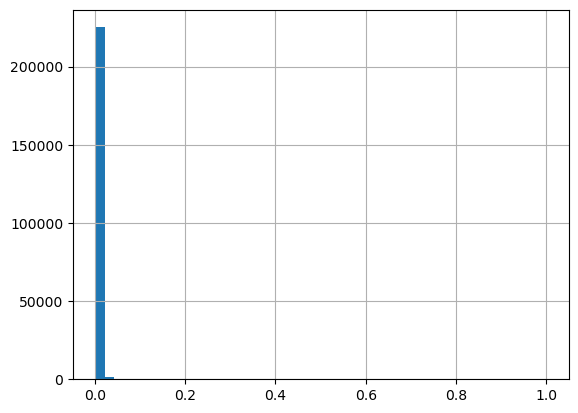

In [26]:
weight_df["weight"].hist(bins=50)

# build community

In [27]:
def louvain_community_lst_func(
    df, resolution=1, node_cols=["node_a", "node_b"], weight_col="weight"
):
    unique_wallets_num = len(columns_unique_items(df, node_cols))
    num_edges = df.shape[0]
    print(f"Number of unique wallets: {unique_wallets_num}")
    print(f"Number of edges: {num_edges}")

    # Create a graph
    G = nx.Graph()

    # Add edges to the graph
    for _, row in df.iterrows():
        G.add_edge(row[node_cols[0]], row[node_cols[1]], weight=row[weight_col])

    communities = algorithms.louvain(G, weight=weight_col, resolution=resolution)

    communities_list = communities.communities
    print(f"Number of communities detected: {len(communities_list)}")
    print("-")
    display(pd.Series([len(community) for community in communities_list]).describe())
    print("")

    communities_list = sorted(communities_list, key=lambda x: len(x), reverse=True)

    return communities_list

In [28]:
def nested_lst_to_loc_dict(nested_lst_):
    loc_dict = {}
    for i, commu in enumerate(nested_lst_):
        for w in commu:
            loc_dict[w] = i
    return loc_dict

### Decide Louvain resolution

In [69]:
commu_count_dict = {}
wallets_count_dict = {}

for r in range(1, 200, 10):
    print(f"Resolution: {r}")
    louvain_community_lst = louvain_community_lst_func(weight_df, resolution=r)
    count = 0
    ttl_wallets = 0
    for i, commu_wallets in enumerate(louvain_community_lst):
        if len(commu_wallets) >= 2:
            count += 1
            ttl_wallets += len(commu_wallets)
    print(f"communities count: {count}")
    print(f"wallets count: {ttl_wallets}")
    print("")
    commu_count_dict[r] = count
    wallets_count_dict[r] = ttl_wallets

Resolution: 1
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 4137
-


count     4137.000000
mean        35.389413
std        482.760836
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max      24352.000000
dtype: float64


communities count: 4137
wallets count: 146406

Resolution: 11
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 5143
-


count    5143.000000
mean       28.467043
std       133.167360
min         2.000000
25%         2.000000
50%         3.000000
75%        10.000000
max      3195.000000
dtype: float64


communities count: 5143
wallets count: 146406

Resolution: 21
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 7917
-


count    7917.000000
mean       18.492611
std        89.747376
min         2.000000
25%         2.000000
50%         3.000000
75%         8.000000
max      3195.000000
dtype: float64


communities count: 7917
wallets count: 146406

Resolution: 31
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 10249
-


count    10249.000000
mean        14.284906
std         70.196392
min          2.000000
25%          2.000000
50%          3.000000
75%          6.000000
max       2530.000000
dtype: float64


communities count: 10249
wallets count: 146406

Resolution: 41
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 11926
-


count    11926.000000
mean        12.276203
std         61.004110
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       2309.000000
dtype: float64


communities count: 11925
wallets count: 146405

Resolution: 51
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 13122
-


count    13122.000000
mean        11.157293
std         55.976830
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       2309.000000
dtype: float64


communities count: 13102
wallets count: 146386

Resolution: 61
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 14270
-


count    14270.000000
mean        10.259706
std         51.683669
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max       2309.000000
dtype: float64


communities count: 14220
wallets count: 146356

Resolution: 71
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 15190
-


count    15190.000000
mean         9.638315
std         48.506621
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 15018
wallets count: 146234

Resolution: 81
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 15856
-


count    15856.000000
mean         9.233476
std         46.612519
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 15600
wallets count: 146150

Resolution: 91
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 16400
-


count    16400.000000
mean         8.927195
std         45.254325
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 16093
wallets count: 146099

Resolution: 101
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 16910
-


count    16910.000000
mean         8.657954
std         44.149251
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 16578
wallets count: 146074

Resolution: 111
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 17311
-


count    17311.000000
mean         8.457397
std         43.330794
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 16948
wallets count: 146043

Resolution: 121
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 17870
-


count    17870.000000
mean         8.192837
std         42.051623
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 17254
wallets count: 145790

Resolution: 131
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 18658
-


count    18658.000000
mean         7.846822
std         40.106435
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 17542
wallets count: 145290

Resolution: 141
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 19396
-


count    19396.000000
mean         7.548257
std         38.521589
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 17743
wallets count: 144753

Resolution: 151
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 20407
-


count    20407.000000
mean         7.174303
std         36.111763
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64


communities count: 17841
wallets count: 143840

Resolution: 161
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 21532
-


count    21532.000000
mean         6.799461
std         33.824736
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max       2282.000000
dtype: float64


communities count: 18042
wallets count: 142916

Resolution: 171
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 22859
-


count    22859.000000
mean         6.404742
std         30.777736
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max       2006.000000
dtype: float64


communities count: 18172
wallets count: 141719

Resolution: 181
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 23991
-


count    23991.000000
mean         6.102538
std         28.692939
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max       1765.000000
dtype: float64


communities count: 18275
wallets count: 140690

Resolution: 191
Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 25188
-


count    25188.000000
mean         5.812530
std         26.863246
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max       1569.000000
dtype: float64


communities count: 18410
wallets count: 139628



In [70]:
# plot i vs count
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=list(commu_count_dict.keys()),
        y=list(commu_count_dict.values()),
        mode="lines+markers",
        name="count",
    )
)

In [38]:
# fig = go.Figure()
# fig.add_trace(
#     go.Scatter(
#         x=list(wallets_count_dict.keys()),
#         y=list(wallets_count_dict.values()),
#         mode="lines+markers",
#         name="communities count",
#     )
# )

### Build real community

In [147]:
louvain_community_lst = louvain_community_lst_func(weight_df, resolution= 150)

Number of unique wallets: 146406
Number of edges: 227616
Number of communities detected: 20324
-


count    20324.000000
mean         7.203602
std         36.306838
min          1.000000
25%          2.000000
50%          2.000000
75%          4.000000
max       2309.000000
dtype: float64

In [33]:
def louvain_community_df_func(louvain_community_lst_):
    louvain_community_df_ = nested_lst_to_loc_dict(louvain_community_lst_)
    louvain_community_df_ = pd.DataFrame.from_dict(
        louvain_community_df_, orient="index", columns=["community"]
    )
    louvain_community_df_["type"] = "normal"
    return louvain_community_df_

In [148]:
louvain_community_df = louvain_community_df_func(louvain_community_lst)
louvain_community_df

,community,type
0x009ed36ca933f4104afe612743d1a0e83824aba4,0,normal
0xdc0eba1d51f87131985aaee259eb66f86ccc4c52,0,normal
0x00aa24d8e4dd504dca0be06716f3d9ef0c9201d5,0,normal
0x00b3639135c1a0f8e5b96813e71166d3926a792c,0,normal
0x00e263c7af6bf8a01fe4af3efd78be38da389ef1,0,normal
...,...,...
0xff15855e37f2d2ca91ceaba24c8fc51689b3d181,20319,normal
0xff47a4e149688a6b89a4423fbb3233bc4984a42a,20320,normal
0xff66c715404797644a352fedef270dabffb37278,20321,normal
0xffac3691e57fc37e5c79b8447ac1fe30d9684431,20322,normal


In [149]:
count = 0
ttl_wallets = 0
for i, commu_wallets in enumerate(louvain_community_lst):
    if len(commu_wallets) >= 2:
        count += 1
        ttl_wallets += len(commu_wallets)
print(count)
print(ttl_wallets)

17845
143927


### plot a community

In [268]:
plot_community_lst = louvain_community_lst[476]
plot_community_df = weight_df[
    weight_df["node_a"].isin(plot_community_lst)
    & weight_df["node_b"].isin(plot_community_lst)
]
print(plot_community_df.shape)
plot_community_df

(41, 4)


,count,node_a,node_b,weight
1197,1,0x007f8278e9b34cdb5e251d9c3845ffb8657de112,0xe2303583c6018d46c4540d44e381af43c9491a8b,0.001520
2819,5,0x016b72a2c5241d467a57947d5d34c518e612970a,0x4d779580155c2e16abf0f541043e28156914b113,0.007599
7920,1,0x043965188f75eab83b7bb7693c1de79fd24abd1e,0xe2303583c6018d46c4540d44e381af43c9491a8b,0.001520
23791,1,0x091ad9b6e8a517ddb84ac583ce2234aa78fa511d,0x4d779580155c2e16abf0f541043e28156914b113,0.001520
27536,1,0x0c07e3f763122907b63d470805956131d95eb2ca,0x4d779580155c2e16abf0f541043e28156914b113,0.001520
27537,1,0x0c07e3f763122907b63d470805956131d95eb2ca,0xe2303583c6018d46c4540d44e381af43c9491a8b,0.001520
41393,1,0x137393f271f9fbb23ff6fe328e02d474553ddc89,0xe2303583c6018d46c4540d44e381af43c9491a8b,0.001520
54196,1,0x1b7dea5871e32cab199fd163eac92cfd7877e5fa,0x4d779580155c2e16abf0f541043e28156914b113,0.001520
63788,1,0x220135a26047861bfbbc3e37e961630cdfb3b57e,0x2916675b462ec4ca0df7f6b61a904928ab32537e,0.001520
74220,1,0x2916675b462ec4ca0df7f6b61a904928ab32537e,0x77836c1368d3fc9f4d945800c6e4420bb8a11639,0.001520


In [238]:
columns_item_count(plot_community_df, w_cols=["node_a", "node_b"])

,wallet,interacted_wallets
0,0x0000090c1a5708bcc5f76f1870aca9f935290820,1
1,0xcbef45f2b07d4afc54f4d1344a051d14e3161ed2,104
2,0x0321be8cbe0c5661bfa294e8e3aedd45c8afe5e0,1
3,0x06503605de2d72d231bcb81c18bf56f43d5d2c2b,1
4,0x071d6cec53c0e76b20430e6a0caa0598cd5fc397,1
...,...,...
100,0xf31ddafbf907b1f76250a55f65cffc8000b98b89,1
101,0xfb195fc36ef8db4ec597a163bf02de988bd3d3e7,1
102,0xfbaaf12735e1cf34728bded55608273ae738b19c,1
103,0xfc981dbedf58acb3dea5a78314507df11eb2fe6d,1


In [37]:
def community_visualization_2d(
    df,
    highlight_lst,
    highlight_lst_2_=None,
    source_col="node_a",
    target_col="node_b",
    weight_col="weight",
    weight_=800,
    height_=800,
):
    # Create a directed graph
    Gt = nx.from_pandas_edgelist(
        df,
        source=source_col,
        target=target_col,
        edge_attr=weight_col,
        create_using=nx.DiGraph(),
    )

    # Generate 2D positions for nodes
    pos = nx.spring_layout(Gt, weight=weight_col)

    # Extract node and edge positions
    edge_x = []
    edge_y = []
    edge_text = []  # List to hold weight information for hover
    for edge in Gt.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_text.append(f"weight: {round(edge[2][weight_col], 2)}")

    node_x = [pos[node][0] for node in Gt.nodes()]
    node_y = [pos[node][1] for node in Gt.nodes()]

    # Determine node colors based on the DataFrame
    node_colors = []
    for node in Gt.nodes():
        if node in highlight_lst:
            node_colors.append("yellowgreen")  # True condition
        elif highlight_lst_2_ and node in highlight_lst_2_:
            node_colors.append("dodgerblue")  # False condition
        else:
            node_colors.append("salmon")

    # Create Plotly figure
    fig = go.Figure()

    # Add edges
    fig.add_trace(
        go.Scatter(
            x=edge_x,
            y=edge_y,
            mode="lines",
            line=dict(color="black", width=2),
            hoverinfo="text",
            text=edge_text,  # Add edge weights to hover info
        )
    )

    # Add nodes
    fig.add_trace(
        go.Scatter(
            x=node_x,
            y=node_y,
            mode="markers",
            marker=dict(size=10, color=node_colors, line=dict(width=1, color="gray")),
            text=list(Gt.nodes()),  # Show node labels
            hoverinfo="text",
        )
    )

    # Update layout
    fig.update_layout(
        showlegend=False,
        width=weight_,
        height=height_,
        xaxis=dict(showgrid=True, zeroline=False),
        yaxis=dict(showgrid=False, zeroline=False),
        # plot_bgcolor="lightgray",
        title="Community Visualization",
    )

    # Show the plot
    fig.show()

In [269]:
community_visualization_2d(
    plot_community_df, oc_wallet_lst, weight_=800, height_=500
)

In [44]:
def community_visualization_3d(
    df,
    highlight_lst,
    highlight_lst_2_=None,
    source_col="node_a",
    target_col="node_b",
    weight_col="weight",
    weight_=800,
    height_=800,
):
    # Create a directed graph
    Gt = nx.from_pandas_edgelist(
        df,
        source=source_col,
        target=target_col,
        edge_attr=weight_col,
        create_using=nx.DiGraph(),
    )

    # Generate 3D positions
    pos = nx.spring_layout(Gt, dim=3, weight=weight_col)

    # Extract node and edge positions
    edge_x = []
    edge_y = []
    edge_z = []
    edge_text = []  # List to hold weight information for hover
    for edge in Gt.edges(data=True):
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])
        edge_text.append(f"weight: {edge[2][weight_col]}")

    node_x = [pos[node][0] for node in Gt.nodes()]
    node_y = [pos[node][1] for node in Gt.nodes()]
    node_z = [pos[node][2] for node in Gt.nodes()]

    # Determine node colors based on the DataFrame
    node_colors = []
    for node in Gt.nodes():
        if node in highlight_lst:
            node_colors.append("yellowgreen")  # True condition
        elif highlight_lst_2_ and node in highlight_lst_2_:
            node_colors.append("dodgerblue")  # False condition
        else:
            node_colors.append("salmon")

    # Create Plotly figure
    fig = go.Figure()

    # Add edges
    fig.add_trace(
        go.Scatter3d(
            x=edge_x,
            y=edge_y,
            z=edge_z,
            mode="lines",
            line=dict(color="black", width=2),
            text=edge_text,
            hoverinfo="text",
        )
    )

    # Add nodes
    fig.add_trace(
        go.Scatter3d(
            x=node_x,
            y=node_y,
            z=node_z,
            mode="markers",
            marker=dict(size=5, color=node_colors),
            text=list(Gt.nodes()),  # Show node labels on hover
            hoverinfo="text",
            textfont=dict(size=5),
            # hoverinfo="none",
        )
    )

    axis_setting = dict(
        showbackground=True,
        titlefont=dict(size=10),
        tickfont=dict(size=10),
    )
    # Update layout
    fig.update_layout(
        showlegend=False,
        width=weight_,
        height=height_,
        scene=dict(
            xaxis=axis_setting,
            yaxis=axis_setting,
            zaxis=axis_setting,
        ),
    )

    # Show the plot
    fig.show()

In [272]:
community_visualization_3d(plot_community_df, oc_wallet_lst, weight_=600, height_=600)

# Get clustering variables

## Community Data

Calculate how many wallets each wallet has interacted with within the community

In [155]:
def columns_item_sum(df_, cols=["node_a", "node_b"], sum_col="tx_count"):
    all_elements = pd.concat(
        [
            df_[[cols[0], sum_col]].rename(columns={cols[0]: "index"}),
            df_[[cols[1], sum_col]].rename(columns={cols[1]: "index"}),
        ]
    )

    # Group by wallet and sum the transaction count
    df_sum_ = all_elements.groupby("index")[sum_col].sum().reset_index()
    return df_sum_

In [156]:
# def clustering_community_info(w_lst, weight_df_=weight_df, sum_col_="tx_count"):
#     w_set = set(w_lst)
#     internal_weight_df = weight_df_[
#         weight_df_["node_a"].apply(w_set.__contains__) & weight_df_["node_b"].apply(w_set.__contains__)
#     ]

#     # Count the number of wallets each wallet interacts with
#     wallet_internal_tx_wallet_df = (
#         internal_weight_df.groupby("node_a")["node_b"].nunique()
#         .reset_index()
#         .rename(columns={"node_a": "wallet", "node_b": "commu_tx_wallets"})
#     )

#     # Compute the sum of transactions for each wallet
#     wallet_internal_tx_count_df = (
#         internal_weight_df.groupby("node_a")[sum_col_].sum()
#         .reset_index()
#         .rename(columns={"node_a": "wallet", sum_col_: "commu_tx_count"})
#     )

#     # merge the two dataframes
#     wallet_internal_tx_wallet_df.set_index("wallet", inplace=True)
#     wallet_internal_tx_count_df.set_index("wallet", inplace=True)

#     wallet_internal_interaction_df = wallet_internal_tx_wallet_df.join(wallet_internal_tx_count_df)

#     return wallet_internal_interaction_df

In [157]:
def clustering_community_info(w_lst, weight_df_, sum_col_="tx_count"):
    w_set = set(w_lst)
    # Filter rows where either node_a or node_b is in the wallet list
    filtered_df = weight_df_[
        weight_df_["node_a"].isin(w_set) & weight_df_["node_b"].isin(w_set)
    ]

    # Combine node_a and node_b into a unified wallet-centric view
    wallet_interactions = pd.concat(
        [
            filtered_df[["node_a", "node_b", sum_col_]].rename(
                columns={"node_a": "wallet", "node_b": "connected_wallet"}
            ),
            filtered_df[["node_b", "node_a", sum_col_]].rename(
                columns={"node_b": "wallet", "node_a": "connected_wallet"}
            ),
        ]
    )

    # Group by wallet to calculate unique connected wallets and transaction sums
    result = (
        wallet_interactions.groupby("wallet")
        .agg(
            commu_tx_wallets=("connected_wallet", "nunique"),
            commu_tx_count=(sum_col_, "sum"),
        )
        .reset_index()
    )

    return result.set_index("wallet")

In [158]:
clustering_community_df = pd.DataFrame()
for i, commu in enumerate(louvain_community_lst):
    if len(commu) < 2:
        continue
    if i % 1000 == 0:
        print(f"Community {i}")
    commu_df = clustering_community_info(commu, weight_df_=weight_df, sum_col_="count")
    clustering_community_df = pd.concat([clustering_community_df, commu_df])

Community 0
Community 1000
Community 2000
Community 3000
Community 4000
Community 5000
Community 6000
Community 7000
Community 8000
Community 9000
Community 10000
Community 11000
Community 12000
Community 13000
Community 14000
Community 15000
Community 16000
Community 17000


In [159]:
clustering_community_df.sort_values("commu_tx_count")

,commu_tx_wallets,commu_tx_count
wallet,,
0x409535809ef4b1929e36f12bc49ac6985ed63af4,1,1
0x541f5fa207c9ede8bef26c510b922a893d5b1fde,1,1
0xc0f2182cd8f12f2811a23ba9c1710c2cd46b6899,1,1
0xc0b18d13bd0384a6ce02c225f032b646b3a77656,1,1
0xc29e6731cd2317c8957ab8bc72e06544aaa05143,1,1
...,...,...
0x34f66b62893969f155fbf4d512480a270ec71bcf,786,2014
0xf39fd6e51aad88f6f4ce6ab8827279cfffb92266,487,2667
0xd788a5fb4729e96fa236caae5959e11100554a88,1606,2798


## Trino data 

"xxx_address_monthly_stats_full"
- address active days
- total gas fee in usd
- number of transaction
- wallets interacted
- last transaction time

-- 

(function is done but not sure if should use due to computational power required)

"xxx_address_last_stats_full"
- number of token types on different chains (ETH on Polygon and ETH on ethereum are different)

--

"xxx_token_transfers_full" (not yet given the computational power required)
- interval in second




In [160]:
def clustering_trino_info_fetch(w_lst, start_date_, end_date_):
    clustering_info = wallets_monthly_info(w_lst, start_date_, end_date_)
    clustering_info_df = pd.DataFrame(clustering_info).T
    clustering_info_df.columns = trino_data_column_names
    return clustering_info_df

In [161]:
def clustering_trino_info(
    w_lst, start_date_, end_date_, existing_df_=None, write_to_path=None
):
    if existing_df_ is not None:
        existing_df_ = existing_df_[existing_df_.index.isin(w_lst)]
        # fetch for the missing wallets
        missing_lst = refine_lst(w_lst, existing_df_.index.tolist())
        if missing_lst:
            missing_df = clustering_trino_info_fetch(
                missing_lst, start_date_, end_date_
            )
            if write_to_path:
                write_to_file_name = os.path.join(
                    write_to_path, f"clustering_trino_{missing_df.index[0]}.csv"
                )
                missing_df.to_csv(write_to_file_name, index=True)
            return pd.concat([existing_df_, missing_df])
        else:
            return existing_df_
    else:
        return clustering_trino_info_fetch(w_lst, start_date_, end_date_)

### Combine data from two sources

In [162]:
def clustering_info(
    w_lst, start_date_, end_date_, existing_df_=None, write_to_path=None
):
    internal_info = clustering_community_info(w_lst)
    trino_info = clustering_trino_info(
        w_lst,
        start_date_,
        end_date_,
        existing_df_=existing_df_,
        write_to_path=write_to_path,
    )
    clustering_info_df = internal_info.merge(
        trino_info, left_index=True, right_index=True
    )

    return clustering_info_df

## clustering_info_df

In [163]:
clustering_info_df = louvain_community_df.copy()
# Merge community information
clustering_info_df = clustering_info_df.merge(
    clustering_community_df,
    left_index=True,
    right_index=True,
    how="left",
)
# merge trino information
clustering_info_df = clustering_info_df.merge(
    trino_monthly_df,
    left_index=True,
    right_index=True,
    how="left",
)
clustering_info_df.fillna(0, inplace=True)
# # Get its real type
# clustering_info_df["answer"] = clustering_info_df.index.map(
#     lambda x: (
#         "airdrop"
#         if x in core_wallet_set
#         else "sybil" if x in sybil_wallet_set else "not_sure"
#     )
# )

In [164]:
clustering_info_df.head()

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days
0x009ed36ca933f4104afe612743d1a0e83824aba4,0,normal,1.0,3.0,0.088248,4.0,2.0,2024-01-04,1.0
0xdc0eba1d51f87131985aaee259eb66f86ccc4c52,0,normal,2308.0,3004.0,0.000000,0.0,0.0,0,0.0
0x00aa24d8e4dd504dca0be06716f3d9ef0c9201d5,0,normal,1.0,2.0,0.068081,3.0,2.0,2024-01-03,1.0
0x00b3639135c1a0f8e5b96813e71166d3926a792c,0,normal,1.0,1.0,0.029518,2.0,2.0,2024-01-03,1.0
0x00e263c7af6bf8a01fe4af3efd78be38da389ef1,0,normal,1.0,1.0,0.028886,2.0,2.0,2024-01-02,1.0


# Clustering

**Why we scale data?**

- If the dataset has features with vastly different scales (e.g., one feature ranges from 0 to 1, while another ranges from 0 to 1000), the feature with the larger scale will dominate the distance calculations. Normalizing data ensures that each feature contributes equally to the distance calculation. This is particularly important in multi-dimensional datasets where features may not have the same units or magnitude.

- we used standardization (Z-Score Scaling): Scales features to have mean = 0 and standard deviation = 1.

In [165]:
def isolation_forest(clustering_info_df, clustring_features, contamination_):
    if contamination_ > 0.5:
        clustering_info_df["isolation_forest"] = -1
        return clustering_info_df
    # Normalize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_info_df[clustring_features])

    # Apply Isolation Forest
    iso = IsolationForest(contamination=contamination_)  # Adjust contamination level
    clustering_info_df["isolation_forest"] = iso.fit_predict(scaled_features)

    return clustering_info_df

In [166]:
def optics_clustering(clustering_info_df, clustring_features, min_samples_=3):
    if len(clustering_info_df) < min_samples_:
        clustering_info_df["optics"] = 0
        return clustering_info_df
    # Normalize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(clustering_info_df[clustring_features])

    # Apply OPTICS clustering
    optics = OPTICS(min_samples=min_samples_)
    clustering_info_df["optics"] = optics.fit_predict(scaled_features)

    return clustering_info_df

In [167]:
def two_step_clustering(
    clustering_info_df,
    iso_features_,
    optics_features_,
    core_num=2,
    optics_min_samples=3,
):
    core_num = min(core_num, np.floor(clustering_info_df.shape[0] / 2))
    if core_num < 1:
        raise ValueError("Core number should be at least 1")
    contamination_ = core_num / clustering_info_df.shape[0]
    clustered_df = clustering_info_df.copy()
    clustered_df = isolation_forest(clustered_df, iso_features_, contamination_)
    middle_info_df = clustered_df[clustered_df["isolation_forest"] != -1]
    # middle_info_df = clustered_df.copy()
    clusted_middle_info_df = optics_clustering(
        middle_info_df, optics_features_, optics_min_samples
    )
    # merge result back to original df
    clustered_df = pd.merge(
        clustered_df,
        clusted_middle_info_df["optics"],
        how="left",
        left_index=True,
        right_index=True,
    )
    clustered_df["type"] = clustered_df.apply(
        lambda x: (
            "sybil_core"
            if x["isolation_forest"] == -1
            else "normal" if x["optics"] == -1 
            else "sybil"
        ),
        axis=1,
    )
    clustered_df["if_core"] = clustered_df.apply(
        lambda x: (1 if x["isolation_forest"] == -1 else 0),
        axis=1,
    )
    return clustered_df

In [168]:
iso_features = ["commu_tx_wallets", "commu_tx_count"]
optics_features = ["gas_fee", "total_txn", "unique_tokens", "unique_active_days"]
optics_features = ["total_txn"]

In [169]:
result_df = clustering_info_df.copy()

In [170]:
for i, commu_wallets in enumerate(louvain_community_lst):
    # Skip small communities early
    if len(commu_wallets) < 2:
        continue

    # Logging progress every 100 iterations
    if i % 100 == 0:
        print(f"Community {i}")

    # Slice the DataFrame for the current community
    commu_df = clustering_info_df.loc[commu_wallets]

    # Perform clustering
    clustered_df = two_step_clustering(
        commu_df, iso_features, optics_features, core_num=2, optics_min_samples=2
    )
    result_df.update(clustered_df)

    # update result_df type
    matching_index = result_df.index.intersection(clustered_df.index)
    result_df.loc[matching_index, "type"] = clustered_df.loc[matching_index, "type"]

Community 0
Community 100
Community 200
Community 300
Community 400
Community 500
Community 600
Community 700
Community 800
Community 900
Community 1000
Community 1100
Community 1200
Community 1300
Community 1400
Community 1500
Community 1600
Community 1700
Community 1800
Community 1900
Community 2000
Community 2100
Community 2200
Community 2300
Community 2400
Community 2500
Community 2600
Community 2700
Community 2800
Community 2900
Community 3000
Community 3100
Community 3200
Community 3300
Community 3400
Community 3500
Community 3600
Community 3700
Community 3800
Community 3900
Community 4000
Community 4100
Community 4200
Community 4300
Community 4400
Community 4500
Community 4600
Community 4700
Community 4800
Community 4900
Community 5000
Community 5100
Community 5200
Community 5300
Community 5400
Community 5500
Community 5600
Community 5700
Community 5800
Community 5900
Community 6000
Community 6100
Community 6200
Community 6300
Community 6400
Community 6500
Community 6600
Communi

In [171]:
short_result_df = result_df

In [172]:
result_df['type'].value_counts()

sybil         124386
sybil_core     12907
normal          9113
Name: type, dtype: int64

In [181]:
result_df

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days
0x009ed36ca933f4104afe612743d1a0e83824aba4,0.0,sybil,1.0,3.0,0.088248,4.0,2.0,2024-01-04,1.0
0xdc0eba1d51f87131985aaee259eb66f86ccc4c52,0.0,sybil_core,2308.0,3004.0,0.000000,0.0,0.0,0,0.0
0x00aa24d8e4dd504dca0be06716f3d9ef0c9201d5,0.0,sybil,1.0,2.0,0.068081,3.0,2.0,2024-01-03,1.0
0x00b3639135c1a0f8e5b96813e71166d3926a792c,0.0,sybil,1.0,1.0,0.029518,2.0,2.0,2024-01-03,1.0
0x00e263c7af6bf8a01fe4af3efd78be38da389ef1,0.0,sybil,1.0,1.0,0.028886,2.0,2.0,2024-01-02,1.0
...,...,...,...,...,...,...,...,...,...
0xff15855e37f2d2ca91ceaba24c8fc51689b3d181,20319.0,normal,0.0,0.0,1.969052,29.0,6.0,2024-11-30,7.0
0xff47a4e149688a6b89a4423fbb3233bc4984a42a,20320.0,normal,0.0,0.0,28.625621,112.0,5.0,2024-12-03,8.0
0xff66c715404797644a352fedef270dabffb37278,20321.0,normal,0.0,0.0,22.286670,90.0,5.0,2024-12-03,8.0
0xffac3691e57fc37e5c79b8447ac1fe30d9684431,20322.0,normal,0.0,0.0,1.972315,29.0,6.0,2024-11-30,7.0


In [190]:
# remove communities with only one wallet
updated_result_df = result_df[result_df['commu_tx_wallets'] > 0]
updated_result_df

,community,type,commu_tx_wallets,commu_tx_count,gas_fee,total_txn,unique_tokens,last_txn_date,unique_active_days
0x009ed36ca933f4104afe612743d1a0e83824aba4,0.0,sybil,1.0,3.0,0.088248,4.0,2.0,2024-01-04,1.0
0xdc0eba1d51f87131985aaee259eb66f86ccc4c52,0.0,sybil_core,2308.0,3004.0,0.000000,0.0,0.0,0,0.0
0x00aa24d8e4dd504dca0be06716f3d9ef0c9201d5,0.0,sybil,1.0,2.0,0.068081,3.0,2.0,2024-01-03,1.0
0x00b3639135c1a0f8e5b96813e71166d3926a792c,0.0,sybil,1.0,1.0,0.029518,2.0,2.0,2024-01-03,1.0
0x00e263c7af6bf8a01fe4af3efd78be38da389ef1,0.0,sybil,1.0,1.0,0.028886,2.0,2.0,2024-01-02,1.0
...,...,...,...,...,...,...,...,...,...
0xf465ec63ec99f77f1a0fdc131eadd3c244e8f173,17842.0,sybil,1.0,4.0,1.188783,5.0,2.0,2024-07-15,5.0
0xfa6e125c35482026273422edeb9514863c8d060f,17843.0,sybil,1.0,3.0,0.849865,3.0,1.0,2024-06-29,3.0
0xfc23e5d766690a075f095ac8afa9dff0f642b3ad,17843.0,sybil,1.0,3.0,13.683955,11.0,8.0,2024-10-27,8.0
0xfcee5798907256faaed7db37bbd5ca702df73eb2,17844.0,sybil,1.0,2.0,2.885015,7.0,3.0,2024-09-01,2.0


In [256]:
all_wallet_df = all_core_wallet_df.copy()
all_wallet_df.index = all_wallet_df["address"]
all_wallet_df = all_wallet_df.merge(updated_result_df[['community', 'type']], left_index=True, right_index=True, how="left")
all_wallet_df['community'] = all_wallet_df['community'].fillna(-1)
all_wallet_df['type'] = all_wallet_df['type'].fillna('normal')
all_wallet_df.loc[all_wallet_df['type'] == 'normal', 'community'] = -1

In [257]:
all_wallet_df[all_wallet_df['community'] == 100]

,address,points,community,type
address,,,,
0xcbef45f2b07d4afc54f4d1344a051d14e3161ed2,0xcbef45f2b07d4afc54f4d1344a051d14e3161ed2,3,100.0,sybil_core


In [274]:
all_wallet_df.to_csv("/Users/floras/Desktop/unique-user/-Data/oc_testnet_15Jan/result/OC_Testnet_Points_SybilResult.csv", index=False)

In [258]:
all_wallet_df['type'].value_counts()

normal        312356
sybil          30245
sybil_core      9041
Name: type, dtype: int64

In [265]:
all_wallet_df[all_wallet_df['type'] == 'sybil_core']['community'].value_counts()

1623.0    2
461.0     2
718.0     2
525.0     2
476.0     2
         ..
6258.0    1
1563.0    1
8251.0    1
4949.0    1
3506.0    1
Name: community, Length: 8007, dtype: int64

In [270]:
all_wallet_df[all_wallet_df['community'] == 476]

,address,points,community,type
address,,,,
0x2916675b462ec4ca0df7f6b61a904928ab32537e,0x2916675b462ec4ca0df7f6b61a904928ab32537e,23,476.0,sybil
0x4d779580155c2e16abf0f541043e28156914b113,0x4d779580155c2e16abf0f541043e28156914b113,5,476.0,sybil_core
0xe2303583c6018d46c4540d44e381af43c9491a8b,0xe2303583c6018d46c4540d44e381af43c9491a8b,1,476.0,sybil_core


# Playground